# Obtener una tabla con las entradas del PDB de proteínas experimentales con los datos de cada entrada

Los datos a insertar en la tabla son:

- PDB EntryID,
- Classification,
- Organismo,
- Uniprot ids,
- Ligand Ids,
- Ligand InChI
- Expermental method,
- Resolución

A la vez que creo la tabla, voy aplicando el filtro.

**FILTROS**:

- No hay ligandos
- Hay el ligando pero está en la "lista negra" (https://github.com/URV-cheminformatics/PDB-CAT/blob/main/blacklist.txt)

**OUTPUT** = Un archivo formato .**csv** donde cada línea representa un complejo ligando-proteína y que almacena información sobre los componentes.




```
# Tiene formato de código

```
# Tiene formato de código
```


```

## Obtener la lista de las entradas pdb

Empiezo con una búsqueda en PDB RCSB (https://www.rcsb.org/).

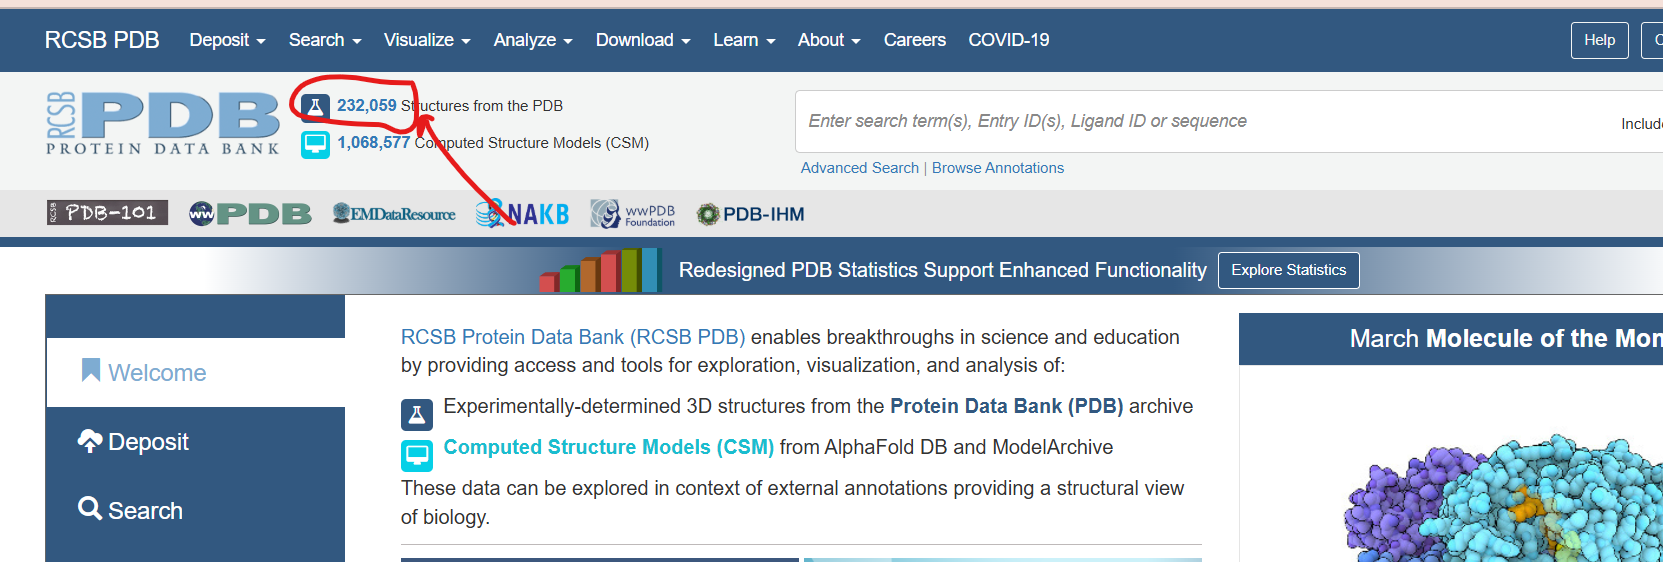

Voy a hacer clic

Seleccionar en la columna de izquierda “protein”.

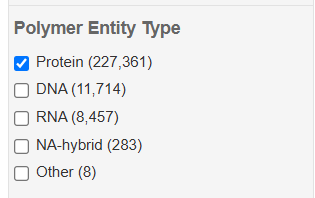





Obtengo **227361** estructuras.

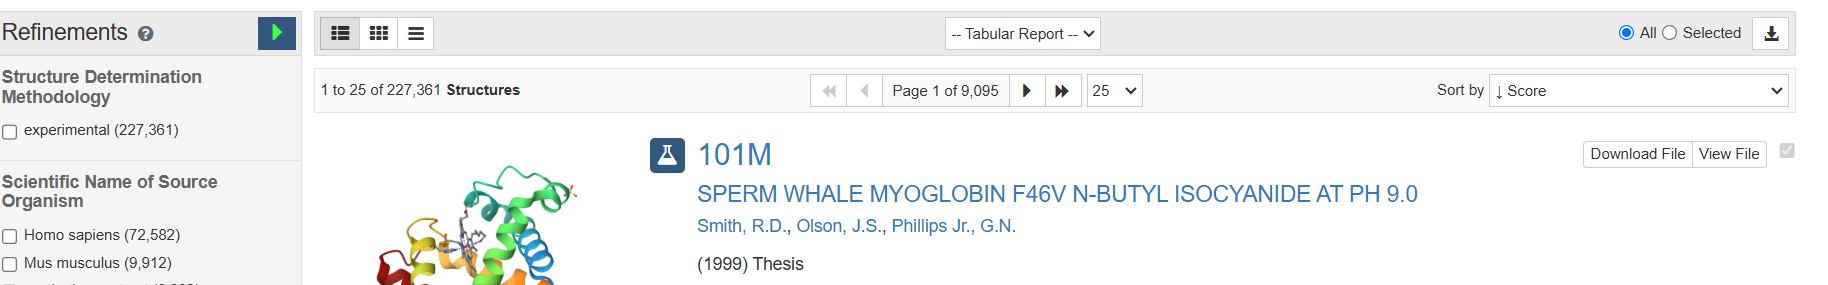

Quiero obtener una tablas con las siguientes columnas:

- PDB EntryID,
- Classification,
- Organismo,
- Uniprot ids,
- Ligand Ids,
- Ligand InChI,
- Expermental method,
- Resolución

Puedo seleccionar al Tabular Report “Entry IDs” puedo obtener la lista de los ids de las entradas PDB que derivan de mi búsqueda.

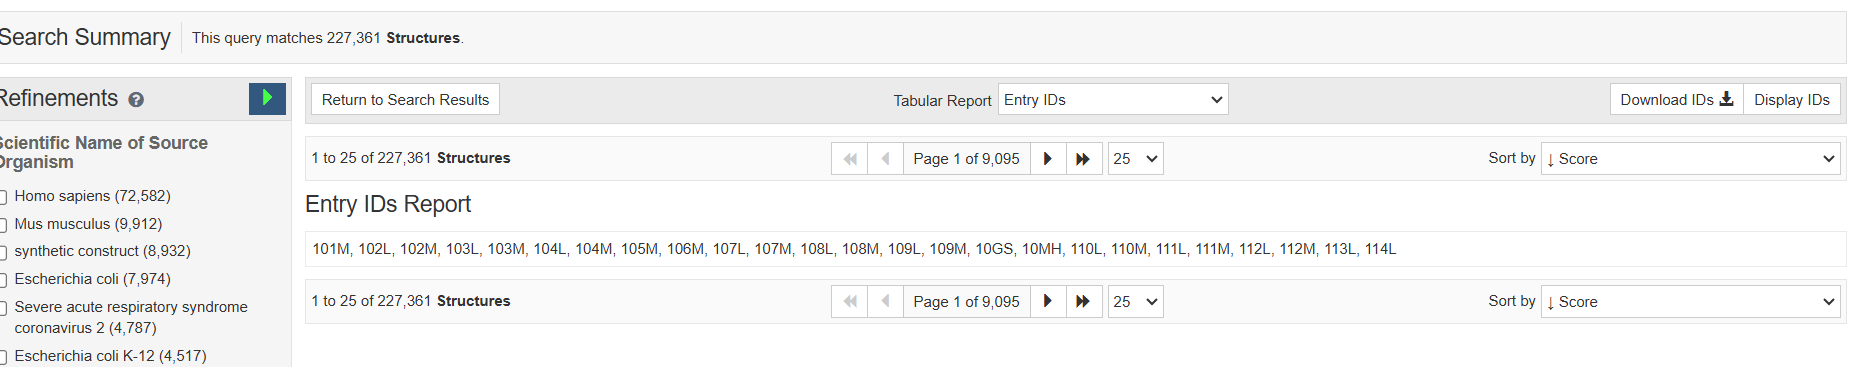

Con el botón **Download IDs** puedo descargarlas en varios archivos **.txt**.

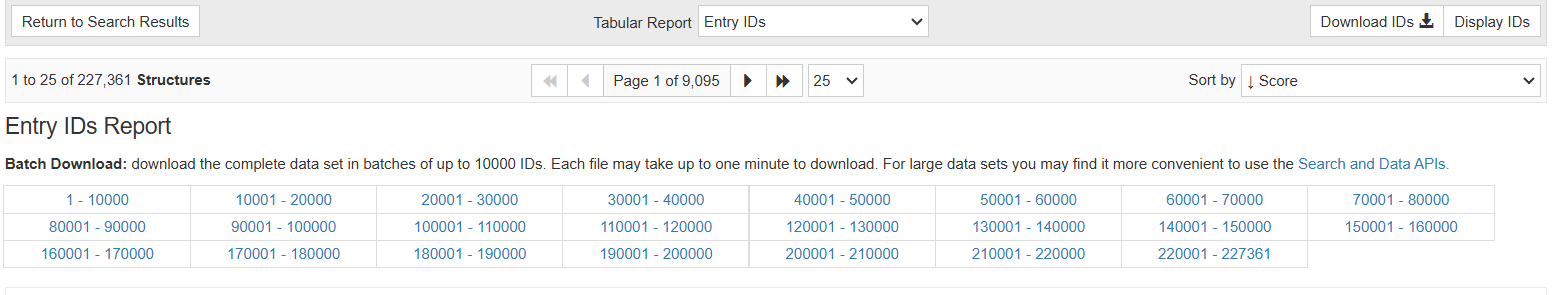

Obtengo archivos de texto **.txt** con los ids que guardo en la misma carpeta.

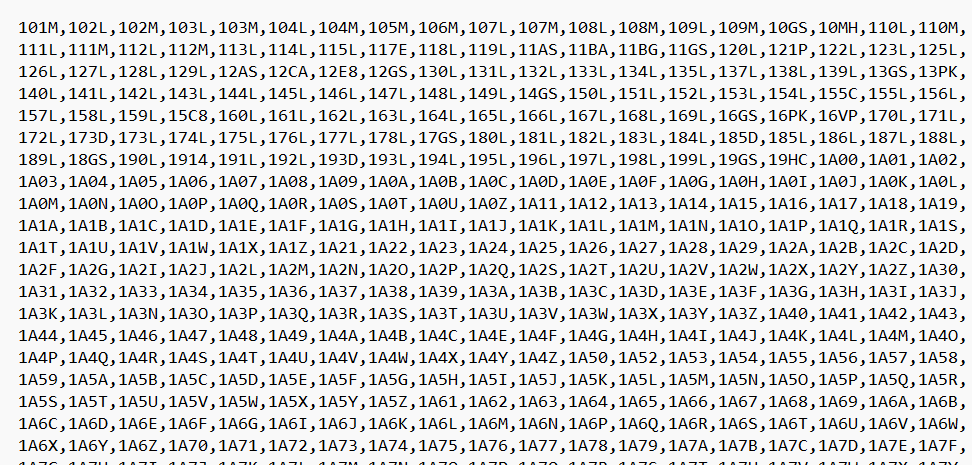

Creo un archivo único que pueda iterar, separo cada entrada en un elemento y guardo todos los ids en una lista.

In [ ]:
#@title Crear la lista con los ids de las entradas PDB

# Abrir archivo único
with open("archivo_unico.txt", "r", encoding="utf-8") as file_ids:
    contenido = file_ids.read()

# Crear una lista con todos los ids de las entradas PDB

lista_pdb_ids = contenido.split(',')
print(f"La lista contiene {len(lista_pdb_ids)} entradas pdb")

La lista contiene 227721 entradas pdb


Luego abro el archivo de la **lista negra** (https://github.com/URV-cheminformatics/PDB-CAT/blob/main/blacklist.txt).



In [ ]:
#@title Cargar y abrir la "lista negra"

with open("blacklist.txt", "r", encoding="utf-8") as blacklist_id:
    contenido_blacklist = blacklist_id.read()

# Sepro por línea y por coma y almaceno todo en una lista
lista_blacklist = [item.strip() for item in contenido_blacklist.replace('\n', ',').split(',')]

#'SO4' in lista_blacklist

FileNotFoundError: [Errno 2] No such file or directory: 'blacklist.txt'

Para obtener la información de las entradas pdb, primero modifico la Qeury que obtengo con la API GraphQL.

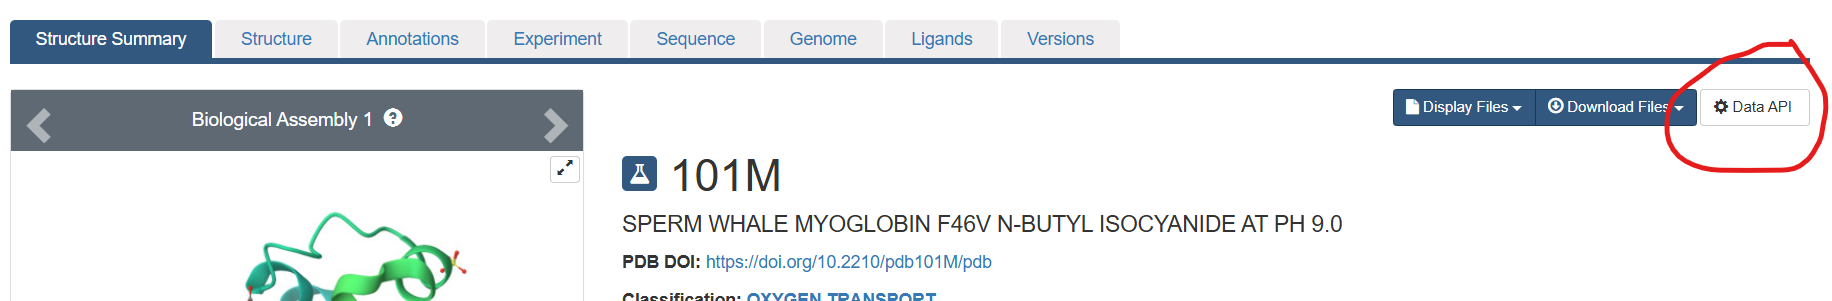

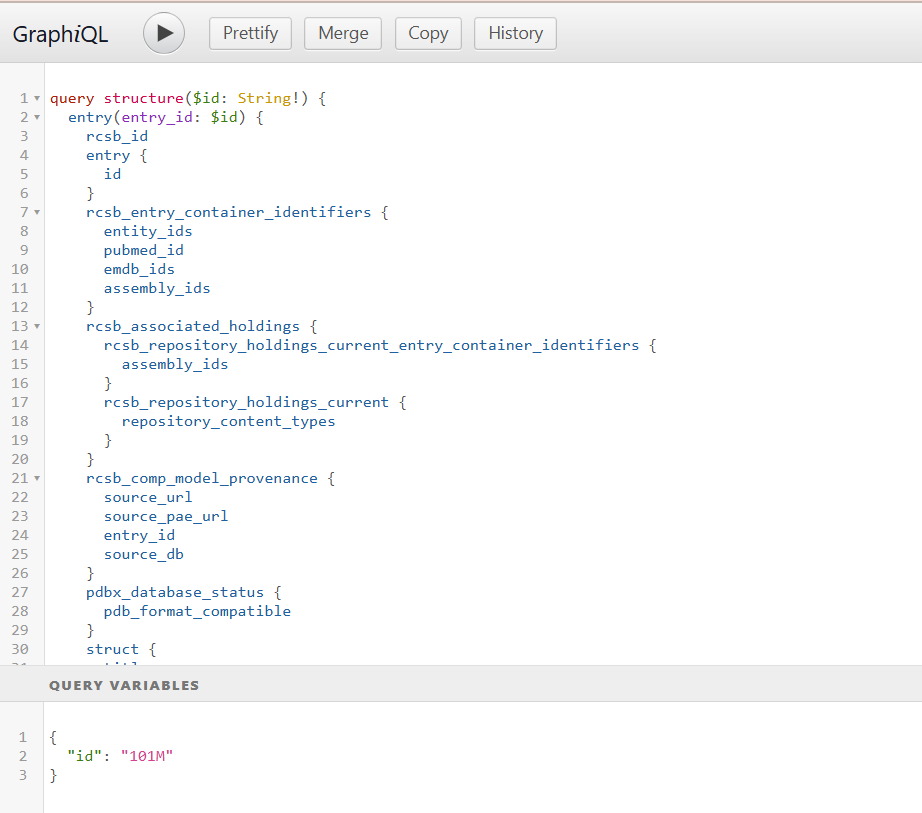

La copio y  la modifico para obtener solo la información que necesito.

In [ ]:
#@title Query más corta

query = """
query structure($id: String!) {
  entry(entry_id: $id) {
    rcsb_id
    entry {
      id
    }
    struct_keywords {
      pdbx_keywords
      text
    }
    exptl {
      method
    }
    refine {
      pdbx_refine_id
      ls_d_res_high
      ls_R_factor_R_work
      ls_R_factor_R_free
      ls_R_factor_obs
    }
    polymer_entities {
      uniprots {
        rcsb_id
        rcsb_uniprot_protein {
          source_organism {
            scientific_name
          }
        }
      }
      rcsb_entity_source_organism {
        scientific_name
        ncbi_scientific_name
        rcsb_gene_name {
          value
          provenance_source
        }
      }
    }
    nonpolymer_entities {
      rcsb_nonpolymer_entity_container_identifiers {
        entry_id
        entity_id
        auth_asym_ids
        asym_ids
        nonpolymer_comp_id
      }
      rcsb_nonpolymer_entity_annotation {
        type
      }
      nonpolymer_entity_instances {
        rcsb_nonpolymer_entity_instance_container_identifiers {
          auth_seq_id
          auth_asym_id
          asym_id
          entry_id
          entity_id
        }
        rcsb_nonpolymer_instance_validation_score {
          ranking_model_fit
          ranking_model_geometry
          average_occupancy
          is_subject_of_investigation
          is_subject_of_investigation_provenance
        }
      }
      rcsb_nonpolymer_entity {
        pdbx_description
      }
      nonpolymer_comp {
        chem_comp {
          id
          formula_weight
          name
          formula
        }
        pdbx_reference_molecule {
          prd_id
          chem_comp_id
          type
          name
          class
        }
        rcsb_chem_comp_descriptor {
          InChIKey
        }
      }
    }
  }
}
"""

Esa es la query con la que puedo realizar la búsqueda a traves de la web, utilizando la función `requests`.

Ahora creo el script de la búsqueda.



In [ ]:
#@title Búsqueda y creación de la tabla de contenido

# Importar las librerías

import csv
import requests

# Definir el url de donde se realizará la búsqueda
url = 'https://data.rcsb.org/graphql'

# Abrir un nuevo archivo formato .csv, en modalidad escritura para almacenar
# la información. Defino los nombres y el orden da las columnas
with open("pdb_structure.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow([
        "PDB_entry_id",
        "Classification",
        "Organism",
        "Uniprot_id",
        "Ligand_id",
        "Ligand_InChi",
        "Experimental_method",
        "Resolution"
    ])

# Itero para cada id en la lista que almacena todos los 277000 ids de las entradas pdb
    for pdb_id in lista_pdb_ids:
        payload = {"query": query, "variables": {"id": pdb_id}}
        response = requests.post(url, json=payload)

# Si la búsqueda me proporciona el código del exito, guardo la información en una variable como
# archivo .json
        if response.status_code == 200:
            q = response.json()

            # 1) entry_id
            q_id = q['data']['entry']['entry']['id']

            # 2) classification

            # CONTROL:
            # Inicializar la variable como una línea vacía en caso de que no haya elementos.
            q_classification = ""

            # Verificar que la estructura que busco está
            if "struct_keywords" in q['data']['entry'] and q['data']['entry']['struct_keywords']:

              # Con el método .get() si hay un valor de "classification" lo asocio a la variable,
              # si no hay nada devuelve "" en lugar que un error.
                q_classification = q['data']['entry']['struct_keywords'].get('pdbx_keywords', "")

            # 3) organism (verifica que la clave "rcsb_entity_source_organism" existe)
            q_organism = ""
            if "polymer_entities" in q['data']['entry'] and q['data']['entry']['polymer_entities']:
                if "rcsb_entity_source_organism" in q['data']['entry']['polymer_entities'][0]:
                    if q['data']['entry']['polymer_entities'][0]['rcsb_entity_source_organism']:
                        q_organism = q['data']['entry']['polymer_entities'][0]['rcsb_entity_source_organism'][0].get('ncbi_scientific_name', "")

            # 4) Uniprot_id (verifica que la clave "uniprots" existe)
            q_uniprot_id = ""
            if 'uniprots' in q['data']['entry']['polymer_entities'][0]:
                if q['data']['entry']['polymer_entities'][0]['uniprots']:  # Si la lista no está vacía
                    q_uniprot_id = q['data']['entry']['polymer_entities'][0]['uniprots'][0]['rcsb_id']

            # 5) Ligands (puede haber más de uno, o ninguno)
            # si hay ligando/s obtengo la lista con los contenidos, si no obtengo una lista vacía
            ligands = q['data']['entry'].get('nonpolymer_entities', [])

            # Asegurar que `ligands` sea una lista válida
            # En caso de haber obtenido "None" en lugar de una lista vacía,
            # se convierte en una lista vacía (evitar errores)
            if ligands is None:
                ligands = []

            # Iterar por cada ligando en la lista de los ligandos
            for ligand in ligands:
                ligand_id = ligand['nonpolymer_comp']['chem_comp']['id']

                # Si el ligando está en la blacklist, lo ignoramos
                if ligand_id in lista_blacklist:
                    continue  # Salta este ligando y sigue con el siguiente

                # 6) Experimental method (verifica si la clave existe)
                q_method = ""
                if "exptl" in q['data']['entry'] and q['data']['entry']['exptl']:
                    q_method = q['data']['entry']['exptl'][0].get('method', "")

                # 7) Resolution (verifica si la clave existe)
                q_resolution = ""
                if "refine" in q['data']['entry'] and q['data']['entry']['refine']:
                    q_resolution = q['data']['entry']['refine'][0].get('ls_d_res_high', "")

                # 8) InChIKey del ligando (verifica si la clave existe)
                ligand_inchi = ""
                if "rcsb_chem_comp_descriptor" in ligand['nonpolymer_comp'] and ligand['nonpolymer_comp']['rcsb_chem_comp_descriptor']:
                    descriptor = ligand['nonpolymer_comp']['rcsb_chem_comp_descriptor']
                    ligand_inchi = descriptor.get('InChIKey', "")

                # Escribir la fila en el CSV
                writer.writerow([
                    q_id,
                    q_classification,
                    q_organism,
                    q_uniprot_id,
                    ligand_id,
                    ligand_inchi,
                    q_method,
                    q_resolution
                ])

        else:
            print(f"Error en la consulta para {pdb_id}: {response.status_code}")


En la práctica, utilice el siguiente código realizando varios archivos .**csv**.

In [ ]:
#@title Crear las tablas con la información (Búsqueda dividida por archivos)

import os
import pandas as pd
import csv
import requests

# Rutas de las carpetas de input y de output
input_folder = '/content/drive/MyDrive/TFM/Desarrollo/T1/ligands_ids'
output_folder = '/content/drive/MyDrive/TFM/Desarrollo/T1'
lista_nera = os.path.join(output_folder, 'blacklist.txt')

# Gestionar la blacklist
with open(lista_nera, "r", encoding="utf-8") as blacklist_id:
    contenido_blacklist = blacklist_id.read()
lista_blacklist = [item.strip() for item in contenido_blacklist.replace('\n', ',').split(',')]

# Averiguar la existencia de la carpeta de input
if os.path.exists(input_folder):
    # Escanear los archivos en la carpeta
    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)

        # Considerar solo los archivos formato .txt
        if os.path.isfile(file_path) and filename.endswith('.txt'):
            # Definir ruta y nombre de los archivos .cvs
            base_name = os.path.splitext(filename)[0]
            csv_filename = base_name + ".csv"
            csv_path = os.path.join(output_folder, csv_filename)

            # Si el .csv existe ya, se salta y se sigue con el siguiente
            if os.path.exists(csv_path):
                print(f"El archivo CSV '{csv_filename}' esiste ya.")
                continue

            print(f"Elaborando el archivo: {filename}")

            # Leer el archivo y crear la lista con los ids
            with open(file_path, "r", encoding="utf-8") as file_ids:
                contenuto = file_ids.read()
                # Dividir el contenido por la coma
                lista_pdb_ids = contenuto.split(',')

            # Definir URL de la búsqueda
            url = 'https://data.rcsb.org/graphql'

            # Abrir el csv en modalidad escritura
            with open(csv_path, "w", newline="", encoding="utf-8") as f:
                writer = csv.writer(f)
                writer.writerow([
                    "PDB_entry_id",
                    "Classification",
                    "Organism",
                    "Uniprot_id",
                    "Ligand_id",
                    "Ligand_InChi",
                    "Experimental_method",
                    "Resolution"
                ])

                # Iterar por cada pdb_id en la lista
                for pdb_id in lista_pdb_ids:
                    # Realizar la búsqueda con la query y obtener el archivo .json
                    payload = {"query": query, "variables": {"id": pdb_id}}
                    response = requests.post(url, json=payload)

                    if response.status_code == 200:
                        q = response.json()

                        # 1) entry_id
                        q_id = q['data']['entry']['entry']['id']

                        # 2) classification
                        q_classification = ""
                        if "struct_keywords" in q['data']['entry'] and q['data']['entry']['struct_keywords']:
                            q_classification = q['data']['entry']['struct_keywords'].get('pdbx_keywords', "")

                        # 3) organism
                        q_organism = ""
                        if "polymer_entities" in q['data']['entry'] and q['data']['entry']['polymer_entities']:
                            if "rcsb_entity_source_organism" in q['data']['entry']['polymer_entities'][0]:
                                if q['data']['entry']['polymer_entities'][0]['rcsb_entity_source_organism']:
                                    q_organism = q['data']['entry']['polymer_entities'][0]['rcsb_entity_source_organism'][0].get('ncbi_scientific_name', "")

                        # 4) Uniprot_id
                        q_uniprot_id = ""
                        if 'uniprots' in q['data']['entry']['polymer_entities'][0]:
                            if q['data']['entry']['polymer_entities'][0]['uniprots']:
                                q_uniprot_id = q['data']['entry']['polymer_entities'][0]['uniprots'][0]['rcsb_id']

                        # 5) Ligands (Puede haber uno, más de uno o ninguno)
                        ligands = q['data']['entry'].get('nonpolymer_entities', [])
                        if ligands is None:
                            ligands = []

                        # Iterar por cada ligando encontrado
                        for ligand in ligands:
                            ligand_id = ligand['nonpolymer_comp']['chem_comp']['id']

                            # Si el ligando está en la "black list" se ignora
                            if ligand_id in lista_blacklist:
                                continue

                            # 6) Experimental method
                            q_method = ""
                            if "exptl" in q['data']['entry'] and q['data']['entry']['exptl']:
                                q_method = q['data']['entry']['exptl'][0].get('method', "")

                            # 7) Resolution
                            q_resolution = ""
                            if "refine" in q['data']['entry'] and q['data']['entry']['refine']:
                                q_resolution = q['data']['entry']['refine'][0].get('ls_d_res_high', "")

                            # 8) InChIKey del ligando
                            ligand_inchi = ""
                            if "rcsb_chem_comp_descriptor" in ligand['nonpolymer_comp'] and ligand['nonpolymer_comp']['rcsb_chem_comp_descriptor']:
                                descriptor = ligand['nonpolymer_comp']['rcsb_chem_comp_descriptor']
                                ligand_inchi = descriptor.get('InChIKey', "")

                            # Escribir una nueva línea del archivo csv
                            writer.writerow([
                                q_id,
                                q_classification,
                                q_organism,
                                q_uniprot_id,
                                ligand_id,
                                ligand_inchi,
                                q_method,
                                q_resolution
                            ])
                    else:
                        print(f"Error en la consulta para {pdb_id}: {response.status_code}")
            print(f"Archivo csv '{csv_filename}' creado correctamente.")
else:
    print(f"La carpeta '{input_folder}' no exsiste.")


Il file CSV 'rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_060001-070000.csv' esiste già. Salto il file 'rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_060001-070000.txt'.
Il file CSV 'rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_040001-050000.csv' esiste già. Salto il file 'rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_040001-050000.txt'.


In [ ]:
!pip install pandas

In [ ]:
import os
import pandas as pd
import csv
import requests

Ahora que he creado los archivos .**csv** voy a abrirlos y a realizar una tabla única.

In [ ]:
#@title Crear tabla única con información entradas pdb
import os
import pandas as pd

# Rutas de las carpetas de input y output
input_folder = '/content/drive/MyDrive/TFM/Desarrollo/T1'
output_folder = '/content/drive/MyDrive/TFM/Desarrollo/T1/Tabla_pdb'

# Crear lista para almacenar los DataFrames
lista_df = []

# Verificar existencia de la carpeta de input
if os.path.exists(input_folder):
    # Escanear los archivos en la carpeta
    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)

        # Considerar solo los archivos .csv
        if os.path.isfile(file_path) and filename.endswith('.csv'):

            # Leer el archivo y agregarlo a la lista
            df = pd.read_csv(file_path, sep=',')
            lista_df.append(df)  # Agregar el DataFrame a la lista

# Unir todos los DataFrames en uno solo
if lista_df:  # Verificar que haya archivos CSV procesados
    df_final = pd.concat(lista_df, ignore_index=True)

    # Definir la ruta del archivo de salida
    output_file = os.path.join(output_folder, "tabla_pdb.csv")

    # Guardar el DataFrame en un CSV
    df_final.to_csv(output_file, index=False)
    print(f"Archivo guardado en: {output_file}")
else:
    print("No se encontraron archivos CSV en la carpeta.")


Leyendo archivo: pdb_structure_1_2_3.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_180001-190000.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_210001-220000.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_170001-180000.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_190001-200000.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_130001-140000.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_220001-227720.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_200001-210000.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_140001-150000.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_160001-170000.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_090001-100000.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_080001-090000.csv
Leyendo archivo: rcsb_pdb_ids_b9c56f2216b562877a35e5e700342e12_07000

# Investigación sobre el dataframe

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125406 entries, 0 to 125405
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           12598 non-null   float64
 1   PDB_entry_id         125406 non-null  object 
 2   Classification       125406 non-null  object 
 3   Organism             124793 non-null  object 
 4   Uniprot_id           119378 non-null  object 
 5   Ligand_id            125406 non-null  object 
 6   Ligand_InChi         124925 non-null  object 
 7   Experimental_method  125406 non-null  object 
 8   Resolution           109053 non-null  float64
dtypes: float64(2), object(7)
memory usage: 8.6+ MB


Se ha obtenido una tabla con **125405** entradas PDB que corresponden a complejos proteínas-ligandos.



In [ ]:
#@title Comprobar si hay y donde hay valores nulos

df_final.isnull().sum()

,0
Unnamed: 0,112808
PDB_entry_id,0
Classification,0
Organism,613
Uniprot_id,6028
Ligand_id,0
Ligand_InChi,481
Experimental_method,0
Resolution,16353


Hay muchos compuestos que no tienen el valor de Resolución.
Esto es porque se almacena en un apartado diferente del archivo **.json** según el **método experimental**.

In [ ]:
df_final['Experimental_method'].value_counts()

,count
Experimental_method,
X-RAY DIFFRACTION,108957
ELECTRON MICROSCOPY,15716
SOLUTION NMR,622
NEUTRON DIFFRACTION,49
ELECTRON CRYSTALLOGRAPHY,46
SOLID-STATE NMR,15
POWDER DIFFRACTION,1


In [ ]:
df_1 = df_final[(df_final['Experimental_method'] =='ELECTRON MICROSCOPY')]
df_1

,Unnamed: 0,PDB_entry_id,Classification,Organism,Uniprot_id,Ligand_id,Ligand_InChi,Experimental_method,Resolution
3741,3741.0,1IA0,TRANSPORT PROTEIN,Sus scrofa,P02550,GDP,QGWNDRXFNXRZMB-UUOKFMHZSA-N,ELECTRON MICROSCOPY,NaN
3742,3742.0,1IA0,TRANSPORT PROTEIN,Sus scrofa,P02550,TXL,ZDZOTLJHXYCWBA-VCVYQWHSSA-N,ELECTRON MICROSCOPY,NaN
3743,3743.0,1IA0,TRANSPORT PROTEIN,Sus scrofa,P02550,ACP,UFZTZBNSLXELAL-IOSLPCCCSA-N,ELECTRON MICROSCOPY,NaN
6206,6206.0,1NN8,Virus/Receptor,Homo sapiens,P15151,MYR,TUNFSRHWOTWDNC-UHFFFAOYSA-N,ELECTRON MICROSCOPY,NaN
7442,7442.0,1Q55,STRUCTURAL PROTEIN,Mus musculus,NaN,NDG,OVRNDRQMDRJTHS-PVFLNQBWSA-N,ELECTRON MICROSCOPY,NaN
...,...,...,...,...,...,...,...,...,...
125136,NaN,3EPC,VIRUS,Homo sapiens,P15151,MYR,TUNFSRHWOTWDNC-UHFFFAOYSA-N,ELECTRON MICROSCOPY,NaN
125137,NaN,3EPD,VIRUS,Homo sapiens,P15151,SPH,WWUZIQQURGPMPG-MSOLQXFVSA-N,ELECTRON MICROSCOPY,NaN
125138,NaN,3EPD,VIRUS,Homo sapiens,P15151,MYR,TUNFSRHWOTWDNC-UHFFFAOYSA-N,ELECTRON MICROSCOPY,NaN
125139,NaN,3EPF,VIRUS,Homo sapiens,P15151,SC4,XXMDDBVNWRWNCW-UHFFFAOYSA-N,ELECTRON MICROSCOPY,NaN


Buscando por varias referencias, veo que las entradas
- "ELECTRON MICROSCOPY"

no tienen valor de Resolution en la tabla pero si que la tienen en el archivo json y se puede rescatar.

Mientras que las entradas
- "SOLUTION NMR",
- "SOLID-STATE NMR"

no tienen valores de resolución que se pueda almacenar.





In [ ]:
#@title Query Resolution para "ELECTRON MICROSCOPY"

query_res_NMR = """
query structure($id: String!) {
  entry(entry_id: $id) {
    rcsb_id
    em_3d_reconstruction {
      resolution
    }
  }
}
    """

In [ ]:
df_prova = df_final.copy()

In [ ]:
#@title Añadir la resolución para los compuestos "ELECTRON MICROSCOPY".


url = 'https://data.rcsb.org/graphql'

# iterar para cada id en el df_final
for index, method in enumerate(df_prova['Experimental_method']):
  if method == 'ELECTRON MICROSCOPY':
    id = df_prova.loc[index, 'PDB_entry_id']
    # Realizar la búsqueda con la query y obtener el archivo .json
    payload = {"query": query_res_NMR, "variables": {"id": id}}
    response = requests.post(url, json=payload)

    if response.status_code == 200:
      data = response.json()

      resolution_EM = ""
      if "em_3d_reconstruction" in data['data']['entry'] and data['data']['entry']['em_3d_reconstruction']:
        resolution_EM = data['data']['entry']['em_3d_reconstruction'][0].get('resolution', "")

        df_prova.loc[index, 'Resolution'] = resolution_EM





In [ ]:
#@title Añadir la resolución para los compuestos "ELECTRON MICROSCOPY".


url = 'https://data.rcsb.org/graphql'

# iterar para cada id en el df_final
for index, method in enumerate(df_final['Experimental_method']):
  if method == 'ELECTRON MICROSCOPY':
    id = df_final.loc[index, 'PDB_entry_id']
    # Realizar la búsqueda con la query y obtener el archivo .json
    payload = {"query": query_res_NMR, "variables": {"id": id}}
    response = requests.post(url, json=payload)

    if response.status_code == 200:
      data = response.json()

      resolution_EM = ""
      if "em_3d_reconstruction" in data['data']['entry'] and data['data']['entry']['em_3d_reconstruction']:
        resolution_EM = data['data']['entry']['em_3d_reconstruction'][0].get('resolution', "")

        # df_final.loc[index, 'Resolution'] = resolution_EM





1IA0 15.0
1IA0 15.0
1IA0 15.0
1NN8 15.0
1Q55 30.0
1Q5A 30.0
1Q5B 30.0
1Q5C 30.0
1UON 7.6
7JK9 3.1
7JK9 3.1
7JKC 1.9
7JLP 3.4
7JLW 2.5
7JM6 2.92
7JM7 2.82
7JM9 2.5
7JMC 2.5
7JMD 2.5
7JN0 2.5
7JN1 2.5
7JN3 3.21
7JN7 3.3
7JPK 3.0
7JPK 3.0
7JPK 3.0
7JPL 3.4
7JPL 3.4
7JPL 3.4
7JPV 3.4


KeyboardInterrupt: 

In [ ]:
df_a_armonizar = df_prova.copy()


In [ ]:
output_file = os.path.join(output_folder, "df_a_armonizar.csv")

df_a_armonizar.to_csv(output_file, index=False)

In [ ]:
output_folder = '/content/drive/MyDrive/TFM/Desarrollo/T1/Tabla_pdb'
archivo_df_a_armonizar = os.path.join(output_folder, "df_a_armonizar.csv")
df_a_armonizar = pd.read_csv(archivo_df_a_armonizar, sep = ',')


## Armonizar la columna de classification

In [ ]:
df_a_armonizar['Classification'].value_counts()



,count
Classification,
TRANSFERASE,17007
HYDROLASE,16137
OXIDOREDUCTASE,12791
MEMBRANE PROTEIN,7444
TRANSPORT PROTEIN,4059
...,...
PROTEIN BINDING/MEMBRANE PROTEIN,1
Odorant-Binding Protein,1
PEPTIDE BINDING PROTEIN/TOXIN,1


Pasos a seguir:

1. Convertir todo en MAYÚSCULO
2. Separar los nombres cuando hay "," o "/"
3. Gestionar cuando hay los parentesis


In [ ]:
df_a_armonizar['Classification'] = df_a_armonizar['Classification'].str.upper()

In [ ]:
classification_counts = df_a_armonizar['Classification'].value_counts().reset_index()
classification_counts.columns = ['Classification', 'Count']
classification_counts

,Classification,Count
0,TRANSFERASE,17007
1,HYDROLASE,16137
2,OXIDOREDUCTASE,12791
3,MEMBRANE PROTEIN,7444
4,TRANSPORT PROTEIN,4059
...,...,...
1781,ACTIN BINDING PROTEIN,1
1782,HYDROLASE/ HYDROLASE INHIBITOR,1
1783,BIFUNCTIONAL ENZYME,1
1784,"LIGASE, PLANT PROTEIN",1


### Gestión "Classification" con paréntesis

In [ ]:
lista_classification_parentesis = [i for i in df_a_armonizar['Classification'] if "(" in i]
print(len(lista_classification_parentesis))

645


In [ ]:
lista_classification_parentesis

['HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'HYDROLASE (O-GLYCOSYL)',
 'COMPLEX (TRANSDUCER/TRANSDUCTION)',
 'COMPLEX (ANTIBODY/ANTIGEN)',
 'COMPLEX (LYASE/INHIBITOR)',
 'HYDROLASE(CARBOXYLIC ESTERASE)',
 'HYDROLASE(CARBOXYLIC ESTERASE)',
 'TRANSFERASE (CARBAMOYL-P,ASPARTATE)',
 'LYASE(CARBON-OXYGEN)',
 'OXIDOREDUCTASE (NAD(A)-CHOH(D))',
 'OXIDOREDUCTASE (NAD(A)-CHOH(D))',
 'HYDROLASE(ACTING IN CYCLICAMIDINES)',
 'OXIDOREDUCTASE(NAD(A)-CHOH(D))',
 'OXIDOREDUCTASE(NAD(A)-CHOH(D))',
 'COMPLEX (SIGNAL TRANSDUCTION/REGULATOR)',
 'TRANSFERASE (GLUTATHIONE)',
 'TRANSFERASE (AMINOTRAN

In [ ]:
parentesis_0 = []
parentesis_1 = []

for i in lista_classification_parentesis:
  palabra_0 = i.split("(")[0].strip(" ")
  parentesis_0.append(palabra_0)
  palabra_1 = i.split("(")[1].strip(")")
  parentesis_1.append(palabra_1)

In [ ]:
from collections import Counter
conteo = Counter(parentesis_0)

print(conteo)

Counter({'HYDROLASE': 260, 'TRANSFERASE': 100, 'COMPLEX': 78, 'OXIDOREDUCTASE': 66, 'ISOMERASE': 51, 'LYASE': 44, 'ELECTRON TRANSPORT': 6, 'TRANSPORT': 5, 'ELECTRON TRANSFER': 5, 'LIGASE': 5, 'BINDING PROTEIN': 4, 'LECTIN': 3, 'HYDROLASE ZYMOGEN': 3, 'OXIDOREDUCTASES': 2, 'ALDOLASE': 2, 'MYOGLOBIN': 2, 'PHOSPHOTRANSFERASE': 2, 'QUINONE-REDUCTASE': 2, 'RAR-RELATED ORPHAN RECEPTOR-G': 2, 'RIFAMYCIN BIOSYNTHESIS': 1, 'REDUCTASE': 1, 'PI': 1})


In [ ]:
conteo = Counter(parentesis_1)

print(conteo)

Counter({'INTRAMOLECULAR OXIDOREDUCTASE': 51, 'O-GLYCOSYL': 50, 'PHOSPHORIC MONOESTER': 31, 'SERINE PROTEINASE': 29, 'METHYLTRANSFERASE': 26, 'ENDORIBONUCLEASE': 24, 'AMINOTRANSFERASE': 23, 'OXO-ACID': 22, 'OXYGENASE': 22, 'PHOSPHORIC DIESTER': 21, 'ACID PROTEASE': 18, 'NAD': 17, 'CARBOXYLIC ESTERASE': 14, 'PHOSPHOTRANSFERASE': 12, 'SERINE PROTEASE': 12, 'CARBON-CARBON': 11, 'CHOH': 11, 'CARBAMOYL-P,ASPARTATE': 10, 'CARBON-OXYGEN': 10, 'GLUTATHIONE': 9, 'ACID PROTEINASE': 9, 'SERINE ESTERASE': 8, 'OXIDOREDUCTASE/PEPTIDE': 8, 'ISOMERASE/KINASE': 7, 'SULFHYDRYL PROTEINASE': 7, 'C-TERMINAL PEPTIDASE': 6, 'BIOTIN-BINDING PROTEIN/PEPTIDE': 6, 'GLUTAMINE AMIDOTRANSFERASE': 5, 'IRON-SULFUR': 5, 'METALLOPROTEINASE': 5, 'SERINE PROTEASE/INHIBITOR': 5, 'ACYLTRANSFERASE': 4, 'THYROXINE': 4, 'IRON-SULFUR PROTEIN': 4, 'GUANYLORIBONUCLEASE': 4, 'GLYCOSYLTRANSFERASE': 4, 'ALPHA-AMINOACYLPEPTIDE': 4, 'NUCLEIC ACID,RNA': 4, 'ACTING IN CYCLIC AMIDES': 3, 'FORMYL': 3, 'PHOSPHOTRANSFERASE/INHIBITOR': 3, '

### Gestió "Classification" con barra

In [ ]:
lista_classification_barra = [i for i in df_a_armonizar['Classification'] if "/" in i and "(" not in i]
print(len(lista_classification_barra))

20355


In [ ]:
lista_classification_barra

['TRANSFERASE/TRANSFERASE INHIBITOR',
 'TRANSFERASE/DNA',
 'TRANSFERASE/TRANSFERASE INHIBITOR',
 'TRANSFERASE/TRANSFERASE INHIBITOR',
 'DNA/ANTIBIOTIC',
 'DNA/ANTIBIOTIC',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'VIRUS/RNA',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'HYDROLASE/HYDROLASE INHIBITOR',
 'BLOOD COAGULATION/HYDROLASE INHIBITOR',
 'CALCIUM/PHOSPHOLIPID B

Puedo crear dos o más columnas y almacenar en la prima, la primera palabra, en la segunda la segunda etc..
Luego compruebo lo que obtengo

In [ ]:
barra_0 = []
barra_1 = []

for i in lista_classification_barra:
  palabra_0 = i.split("/")[0]
  barra_0.append(palabra_0)
  palabra_1 = i.split("/")[1]
  barra_1.append(palabra_1)




In [ ]:
conteo = Counter(barra_0)

print(conteo)
df_conteo = pd.DataFrame(conteo.items(), columns=['Valor', 'Frecuencia']).sort_values(by='Frecuencia', ascending=False)
df_conteo

Counter({'TRANSFERASE': 5946, 'HYDROLASE': 5406, 'OXIDOREDUCTASE': 2370, 'TRANSCRIPTION': 623, 'LYASE': 620, 'LIGASE': 451, 'VIRAL PROTEIN': 391, 'SIGNALING PROTEIN': 391, 'ISOMERASE': 323, 'MEMBRANE PROTEIN': 269, 'TRANSPORT PROTEIN': 245, 'DNA BINDING PROTEIN': 241, 'PROTEIN BINDING': 193, 'RIBOSOME': 165, 'REPLICATION': 141, 'HORMONE': 139, 'OXYGEN STORAGE': 131, 'STRUCTURAL PROTEIN': 131, 'CHAPERONE': 104, 'CELL CYCLE': 103, 'IMMUNE SYSTEM': 101, 'VIRAL PROTEIN,HYDROLASE': 96, 'RNA BINDING PROTEIN': 91, 'REPLICATION, TRANSFERASE': 80, 'TRANSFERASE, LYASE': 79, 'GENE REGULATION': 77, 'VIRAL PROTEIN, HYDROLASE': 74, 'APOPTOSIS': 60, 'PROTEIN TRANSPORT': 57, 'TRANSCRIPTION, TRANSFERASE': 56, 'SUGAR BINDING PROTEIN': 53, 'PHOTOSYNTHESIS': 47, 'CELL ADHESION': 39, 'METAL BINDING PROTEIN': 36, 'HORMONE RECEPTOR': 35, 'BLOOD CLOTTING': 31, 'TRANSFERASE, HYDROLASE': 31, 'ONCOPROTEIN': 30, 'TOXIN': 27, 'TRANSCRIPTION REGULATOR': 26, 'VIRUS': 24, 'TRANSLATION': 24, 'DNA': 23, 'HYDROLASE, VIR

,Valor,Frecuencia
0,TRANSFERASE,5946
2,HYDROLASE,5406
17,OXIDOREDUCTASE,2370
8,TRANSCRIPTION,623
14,LYASE,620
...,...,...
118,THANSFERASE,1
170,RECEPTOR,1
121,LIGASE,1
122,"HYDROLASE, LYASE",1


En algunas entradas, hay líneas con la coma.

In [ ]:
barra_0_0 = []
barra_0_1 = []

for i in barra_0:
  if "," in i.strip(" "):
    palabra_0 = i.split(",")[0]
    barra_0_0.append(palabra_0)
    palabra_1 = i.split(",")[1]
    barra_0_1.append(palabra_1)
  else:
    barra_0_0.append("NO")
    barra_0_1.append("NO")


In [ ]:
conteo = Counter(barra_0_1)

print(conteo)

Counter({'NO': 19646, ' TRANSFERASE': 185, 'HYDROLASE': 135, ' HYDROLASE': 124, ' LYASE': 96, 'TRANSFERASE': 49, 'LYASE': 30, ' VIRAL PROTEIN': 23, 'VIRAL PROTEIN': 12, 'ONCOPROTEIN': 10, 'OXIDOREDUCTASE': 9, ' DNA BINDING PROTEIN': 5, ' SIGNALING PROTEIN': 4, 'REPLICATION': 3, ' LIGASE': 3, 'SIGNALING PROTEIN': 3, 'ENDOCYTOSIS': 2, 'LIGASE': 2, ' SUGAR BINDING PROTEIN': 2, ' ISOMERASE': 2, ' REPLICATION': 1, 'ANTITOXIN': 1, ' MEMBRANE PROTEIN': 1, ' RECEPTOR': 1, ' CHAPERONE': 1, ' PROTEIN BINDING': 1, ' TRANSCRIPTION': 1, ' OXIDOREDUCTASE': 1, 'APOPTOSIS': 1, ' VIRUS': 1})


### Gestión de "Classification" con coma

In [ ]:
lista_classification_coma = [i.strip() for i in df_a_armonizar['Classification'] if "," in i.strip(" ") and "/" not in i and "(" not in i]
print(len(lista_classification_coma))

1809


In [ ]:
lista_classification_coma

['OXIDOREDUCTASE,HYDROLASE',
 'OXIDOREDUCTASE,HYDROLASE',
 'OXIDOREDUCTASE,HYDROLASE',
 'OXIDOREDUCTASE,LYASE',
 'OXIDOREDUCTASE,LYASE',
 'OXIDOREDUCTASE,LYASE',
 'OXIDOREDUCTASE,LYASE',
 'OXIDOREDUCTASE,LYASE',
 'OXIDOREDUCTASE,LYASE',
 'VIRAL PROTEIN, TRANSFERASE',
 'VIRAL PROTEIN, TRANSFERASE',
 'PROTON TRANSPORT, MEMBRANE PROTEIN',
 'PROTON TRANSPORT, MEMBRANE PROTEIN',
 'PROTON TRANSPORT, MEMBRANE PROTEIN',
 'PROTON TRANSPORT, MEMBRANE PROTEIN',
 'PROTON TRANSPORT, MEMBRANE PROTEIN',
 'PROTON TRANSPORT, MEMBRANE PROTEIN',
 'VIRAL PROTEIN, HYDROLASE',
 'VIRAL PROTEIN, HYDROLASE',
 'VIRAL PROTEIN, HYDROLASE',
 'VIRAL PROTEIN, HYDROLASE',
 'VIRAL PROTEIN, HYDROLASE',
 'TRANSFERASE, CELL CYCLE',
 'TRANSFERASE, CELL CYCLE',
 'IMMUNE SYSTEM, MEMBRANE PROTEIN',
 'IMMUNE SYSTEM, MEMBRANE PROTEIN',
 'IMMUNE SYSTEM, MEMBRANE PROTEIN',
 'CELL CYCLE, HYDROLASE',
 'TRANSFERASE, HYDROLASE',
 'BLOOD CLOTTING, HYDROLASE',
 'BLOOD CLOTTING, HYDROLASE',
 'BLOOD CLOTTING, HYDROLASE',
 'BLOOD CLOTTIN

In [ ]:
coma_0 = []
coma_1 = []

for i in lista_classification_coma:
  palabra_0 = i.strip(" ").split(",")[0]
  coma_0.append(palabra_0.strip(" "))
  palabra_1 = i.strip(" ").split(",")[1]
  coma_1.append(palabra_1.strip(" "))

In [ ]:
conteo = Counter(coma_1)
print(conteo)

Counter({'HYDROLASE': 495, 'TRANSFERASE': 195, 'UNKNOWN FUNCTION': 191, 'PHOTOSYNTHESIS': 126, 'TRANSPORT PROTEIN': 106, 'OXIDOREDUCTASE': 79, 'MEMBRANE PROTEIN': 70, 'ELECTRON TRANSPORT': 67, 'LYASE': 59, 'SIGNALING PROTEIN': 38, 'TRANSCRIPTION': 23, 'ISOMERASE': 22, 'VIRAL PROTEIN': 22, 'PROTEIN BINDING': 21, 'RECEPTOR': 21, 'METAL TRANSPORT': 21, 'SUGAR BINDING PROTEIN': 20, 'LIGASE': 19, 'IMMUNE SYSTEM': 17, 'DNA BINDING PROTEIN': 15, 'OXYGEN TRANSPORT': 14, 'METAL BINDING PROTEIN': 12, 'TOXIN': 11, 'APOPTOSIS': 11, 'CELL CYCLE': 10, 'BLOOD CLOTTING': 9, 'TRANSLOCASE': 9, 'FLUORESCENT PROTEIN': 9, 'PLANT PROTEIN': 8, 'LIGAND BINDING PROTEIN': 7, 'BIOSYNTHETIC PROTEIN': 7, 'RECOMBINATION': 6, 'STRUCTURAL PROTEIN': 5, 'REPLICATION': 4, 'RNA BINDING PROTEIN': 4, 'ANTIMICROBIAL PROTEIN': 4, 'PROTEIN TRANSPORT': 4, 'TRANSLATION': 3, 'ANTITUMOR PROTEIN': 3, 'LIPID BINDING PROTEIN': 3, 'CHAPERONE': 3, 'EXOCYTOSIS': 3, 'LIPID TRANSPORT': 3, 'DNA REPAIR': 2, 'PROTEIN FIBRIL': 2, 'INHIBITOR'

In [ ]:
df_class = df_a_armonizar[['PDB_entry_id','Classification']]

In [ ]:
df_class['Adding_Classification'] = None
df_class

<ipython-input-170-6a1134abf88a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_class['Adding_Classification'] = None


,PDB_entry_id,Classification,Adding_Classification
0,101M,OXYGEN TRANSPORT,None
1,103M,OXYGEN TRANSPORT,None
2,104M,OXYGEN TRANSPORT,None
3,105M,OXYGEN TRANSPORT,None
4,106M,OXYGEN TRANSPORT,None
...,...,...,...
125401,3F68,HYDROLASE/HYDROLASE INHIBITOR,None
125402,3F69,TRANSFERASE,None
125403,3F6B,LYASE,None
125404,3F6D,TRANSFERASE,None


In [ ]:
for index,classification in enumerate(df_class['Classification']):

  #Gestión palabras con paréntesis

  if "(" in classification.strip(" "):
    palabra_0 = classification.split("(")[0].strip(" ")
    palabra_1 = classification.split("(")[1].strip(")")

    # Si existe se cambia
    df_class.loc[index,'Classification'] = palabra_0
    df_class.loc[index,'Adding_Classification'] = palabra_1

  # Gestión palabras con barra

  elif "/" in classification.strip(" ") and "(" not in classification.strip(" "):
      palabra_0 = classification.split("/")[0]
      if "," in palabra_0.strip(" "):
        palabra_0_0 = classification.split(",")[0]
        df_class.loc[index,'Classification'] = palabra_0_0
        palabra_0_1 = classification.split(",")[1]
        df_class.loc[index,'Adding_Classification'] = palabra_0_1
      else:
        df_class.loc[index,'Classification'] = palabra_0
        palabra_1 = classification.split("/")[1]
        df_class.loc[index,'Adding_Classification'] = palabra_1

    # Gestión palabras con coma

  elif "," in classification.strip(" ") and "(" not in classification.strip(" ") and "/" not in classification.strip(" "):
      palabra_0 = classification.strip(" ").split(",")[0]
      palabra_1 = classification.strip(" ").split(",")[1]
      df_class.loc[index,'Classification'] = palabra_0
      df_class.loc[index,'Adding_Classification'] = palabra_1








In [ ]:
df_harm = df_a_armonizar.copy()

In [ ]:
for index,classification in enumerate(df_harm['Classification']):

  #Gestión palabras con paréntesis

  if "(" in classification.strip(" "):
    palabra_0 = classification.split("(")[0].strip(" ")
    palabra_1 = classification.split("(")[1].strip(")")

    # Si existe se cambia
    df_harm.loc[index,'Classification'] = palabra_0
    df_harm.loc[index,'Adding_Classification'] = palabra_1

  # Gestión palabras con barra

  elif "/" in classification.strip(" ") and "(" not in classification.strip(" "):
      palabra_0 = classification.split("/")[0]
      if "," in palabra_0.strip(" "):
        palabra_0_0 = classification.split(",")[0]
        df_harm.loc[index,'Classification'] = palabra_0_0
        palabra_0_1 = classification.split(",")[1]
        df_harm.loc[index,'Adding_Classification'] = palabra_0_1
      else:
        df_harm.loc[index,'Classification'] = palabra_0
        palabra_1 = classification.split("/")[1]
        df_harm.loc[index,'Adding_Classification'] = palabra_1

    # Gestión palabras con coma

  elif "," in classification.strip(" ") and "(" not in classification.strip(" ") and "/" not in classification.strip(" "):
      palabra_0 = classification.strip(" ").split(",")[0]
      palabra_1 = classification.strip(" ").split(",")[1]
      df_harm.loc[index,'Classification'] = palabra_0
      df_harm.loc[index,'Adding_Classification'] = palabra_1

In [ ]:
import os
output_folder = '/content/drive/MyDrive/TFM/Desarrollo/T1'
output_file = os.path.join(output_folder, "df_harm.csv")

df_harm.to_csv(output_file, index=False)

NameError: name 'os' is not defined

In [ ]:
method_not_allowed = ['SOLUTION NMR','SOLID-STATE NMR']

df_harm = df_harm[df_harm['Experimental_method'] != method_not_allowed]

In [ ]:
df_harm_count_class_principal = df_harm['Classification'].value_counts().reset_index()
df_harm_count_class_principal.columns = ['Classification', 'Count']
#df_harm_count_class_principal

NameError: name 'df_harm' is not defined

In [ ]:
df_harm_count_adding_class = df_harm['Adding_Classification'].value_counts().reset_index()
df_harm_count_adding_class.columns = ['Adding_Classification', 'Count']
df_harm_count_adding_class

,Adding_Classification,Count
0,HYDROLASE INHIBITOR,4057
1,TRANSFERASE INHIBITOR,3603
2,INHIBITOR,3439
3,DNA,1979
4,OXIDOREDUCTASE INHIBITOR,1652
...,...,...
433,RECEPTOR/AGONIST,1
434,GROWTH FACTOR/GROWTH FACTOR,1
435,OXIDOREDUCTASE INHIBITOR,1
436,PROTEIN,1


In [ ]:
#@title Resolución

df_ordenado_desc = df_harm.sort_values(by='Resolution', ascending=False)
df_ordenado_desc


,Unnamed: 0,PDB_entry_id,Classification,Organism,Uniprot_id,Ligand_id,Ligand_InChi,Experimental_method,Resolution,Adding_Classification
68138,NaN,6U3G,ENDOCYTOSIS,Homo sapiens,O43739,4IP,CIPFCGZLFXVXBG-CNWJWELYSA-N,ELECTRON MICROSCOPY,53.0,NaN
68136,NaN,6U3E,ENDOCYTOSIS,Homo sapiens,O43739,4IP,CIPFCGZLFXVXBG-CNWJWELYSA-N,ELECTRON MICROSCOPY,53.0,NaN
60062,NaN,6BBQ,LIPID BINDING PROTEIN,Mus musculus,P62330,4IP,CIPFCGZLFXVXBG-CNWJWELYSA-N,ELECTRON MICROSCOPY,35.0,NaN
60061,NaN,6BBP,LIPID BINDING PROTEIN,Mus musculus,P62330,4IP,CIPFCGZLFXVXBG-CNWJWELYSA-N,ELECTRON MICROSCOPY,35.0,NaN
7444,7444.0,1Q5B,STRUCTURAL PROTEIN,Mus musculus,NaN,NDG,OVRNDRQMDRJTHS-PVFLNQBWSA-N,ELECTRON MICROSCOPY,30.0,NaN
...,...,...,...,...,...,...,...,...,...,...
123466,NaN,2I18,METAL BINDING PROTEIN,Entamoeba histolytica,P38505,LA,CZMAIROVPAYCMU-UHFFFAOYSA-N,SOLUTION NMR,NaN,NaN
124326,NaN,2JMG,VIRAL PROTEIN,Human immunodeficiency virus 1,Q6E183,MYR,TUNFSRHWOTWDNC-UHFFFAOYSA-N,SOLUTION NMR,NaN,NaN
124327,NaN,2JN3,LIPID BINDING PROTEIN,Gallus gallus,P80226,JN3,RUDATBOHQWOJDD-BSWAIDMHSA-N,SOLUTION NMR,NaN,NaN
124328,NaN,2JNP,HYDROLASE,Homo sapiens,P08254,NGH,JIRXORZYIXSWOB-UHFFFAOYSA-N,SOLUTION NMR,NaN,NaN
